In [1]:
import numpy as np
import pandas as pd
import glob

pd.options.display.float_format = '{:.4f}'.format

In [2]:
file_list = glob.glob("data/split_*.csv") # ['data/split_1.csv', ... ,'data/split_5.csv']

df = pd.concat([pd.read_csv(file) for file in file_list], # list comprehension, supposedly faster than for loop
               ignore_index=True
               )

In [81]:
# len(df): 889930 rows
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889930 entries, 0 to 889929
Data columns (total 48 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   CRASH_RECORD_ID                889930 non-null  object 
 1   CRASH_DATE_EST_I               65794 non-null   object 
 2   CRASH_DATE                     889930 non-null  object 
 3   POSTED_SPEED_LIMIT             889930 non-null  int64  
 4   TRAFFIC_CONTROL_DEVICE         889930 non-null  object 
 5   DEVICE_CONDITION               889930 non-null  object 
 6   WEATHER_CONDITION              889930 non-null  object 
 7   LIGHTING_CONDITION             889930 non-null  object 
 8   FIRST_CRASH_TYPE               889930 non-null  object 
 9   TRAFFICWAY_TYPE                889930 non-null  object 
 10  LANE_CNT                       199019 non-null  float64
 11  ALIGNMENT                      889930 non-null  object 
 12  ROADWAY_SURFACE_COND          

## Data Cleaning

In [3]:
# No. of cols with missing values
df.isnull().any().sum() #: 26 (out of 47)

26

In [4]:
def clean_data(df):

    # Fill missing values in CRASH_DATE_EST_I with 'N'
    df['CRASH_DATE_EST_I'] = df['CRASH_DATE_EST_I'].fillna('N')
    # Fill missing REPORT_TYPE with 'NO_REPORT'
    df['REPORT_TYPE'] = df['REPORT_TYPE'].fillna('NO_REPORT') ####!!!!!!!!!!!!!!!!
    # Fill missing values with 'N'
    df[['INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I']] = df[['INTERSECTION_RELATED_I', 'NOT_RIGHT_OF_WAY_I', 'HIT_AND_RUN_I']].fillna('N')
    # Transform CRASH_DATE and DATE_POLICE_NOTIFIED to date formats
    df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])
    df['DATE_POLICE_NOTIFIED'] = pd.to_datetime(df['DATE_POLICE_NOTIFIED'])
    # Create new column Report_vs_Police_Notified
    df['Report_vs_Police_Notified'] = (df['DATE_POLICE_NOTIFIED'] - df['CRASH_DATE']).dt.total_seconds() / 3600
    # Cap Report_vs_Police_Notified at 48 hours, lower at 0
    df['Report_vs_Police_Notified'] = df['Report_vs_Police_Notified'].clip(lower=0, upper=48)
    # Drop column: 'PHOTOS_TAKEN_I'
    df = df.drop(columns=['PHOTOS_TAKEN_I'])
    # Drop column: 'STATEMENTS_TAKEN_I'
    df = df.drop(columns=['STATEMENTS_TAKEN_I'])
    # Fill missing values with 'N' for specified columns
    df[['DOORING_I', 'WORK_ZONE_I', 'WORKERS_PRESENT_I']] = df[['DOORING_I', 'WORK_ZONE_I', 'WORKERS_PRESENT_I']].fillna('N')
    
    ####################
    # Fill missing values with 'UNKNOWN': 'WORK_ZONE_TYPE'
    df['WORK_ZONE_TYPE'] = df['WORK_ZONE_TYPE'].fillna('UNKNOWN') ####!!!!!!!!!!!!!!!!
    ####################
    # Fill missing values with '-1'!!: 'LANE_CNT'
    df['LANE_CNT'] = df['LANE_CNT'].fillna(-1).astype(int)
    df['LANE_CNT'] = pd.cut(
        df['LANE_CNT'], 
        bins=[-float('inf'), 0, 3, 6, 12, float('inf')], 
        labels=['NA_low', 'NARROW', 'WIDE', 'HIGHWAY', 'NA_high'], 
        right=True,
        )
    df['LANE_CNT'] = df['LANE_CNT'].replace({'NA_low': 'NOT_APPLICABLE', 
                                             'NA_high': 'NOT_APPLICABLE'})
    ####################
    # Extract year from 'CRASH_DATE' 
    df['Crash_Year'] = df['CRASH_DATE'].dt.year

    ####################
    # BEAT_OF_OCCURRENCE
    # we need to group into 5 (or 25) categories
    def assign_district(beat):
        if pd.notna(beat):  
            district = int(beat) // 100  # Extract the first part of the number (e.g., 111 -> 1)
            if 1 <= district <= 25:
                return f"District {district:02}"  # Format as "District 01", "District 25", etc.
        return "UNKNOWN"

    df['Police_district'] = df['BEAT_OF_OCCURRENCE'].apply(assign_district)
    
    
    
    # Drop column: 'INJURIES_UNKNOWN'
    df = df.drop(columns=['INJURIES_UNKNOWN'])
    # Drop column: 'LOCATION'
    df = df.drop(columns=['LOCATION'])
    return df

df_clean = clean_data(df.copy())
#del df

df_clean.head()


/var/folders/g7/y52dk3zx0z96gzkblc1nqmlw0000gn/T/ipykernel_52386/3415961696.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])
/var/folders/g7/y52dk3zx0z96gzkblc1nqmlw0000gn/T/ipykernel_52386/3415961696.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE_POLICE_NOTIFIED'] = pd.to_datetime(df['DATE_POLICE_NOTIFIED'])
/var/folders/g7/y52dk3zx0z96gzkblc1nqmlw0000gn/T/ipykernel_52386/3415961696.py:35: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories inste

,CRASH_RECORD_ID,CRASH_DATE_EST_I,CRASH_DATE,POSTED_SPEED_LIMIT,TRAFFIC_CONTROL_DEVICE,DEVICE_CONDITION,WEATHER_CONDITION,LIGHTING_CONDITION,FIRST_CRASH_TYPE,TRAFFICWAY_TYPE,...,INJURIES_REPORTED_NOT_EVIDENT,INJURIES_NO_INDICATION,CRASH_HOUR,CRASH_DAY_OF_WEEK,CRASH_MONTH,LATITUDE,LONGITUDE,Report_vs_Police_Notified,Crash_Year,Police_district
0,9c8cd8acb0580e5d205611e5235ffe191ecefaa80cf51b...,Y,2018-03-26 14:00:00,20,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,PARKED MOTOR VEHICLE,ONE-WAY,...,0.0000,1.0000,14,2,3,41.9294,-87.7456,24.5000,2018,District 25
1,9c8cf896919a5eb64bbf23ae23f6ed0291d367e98ab907...,N,2024-04-27 14:00:00,30,UNKNOWN,UNKNOWN,CLOUDY/OVERCAST,DAYLIGHT,REAR END,NOT DIVIDED,...,0.0000,2.0000,14,7,4,41.9398,-87.6540,0.4167,2024,District 19
2,9c8cfd3d40be79b1e2689507eb00075c752c2df969f0dd...,N,2018-12-21 12:45:00,30,NO CONTROLS,NO CONTROLS,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,0.0000,2.0000,12,6,12,41.9000,-87.6478,0.0167,2018,District 18
3,9c8d108e33b3f9c0ff819b1db7d87a418815d1ef301ad5...,N,2018-06-08 17:13:00,35,STOP SIGN/FLASHER,UNKNOWN,CLEAR,DAYLIGHT,REAR END,DIVIDED - W/MEDIAN (NOT RAISED),...,0.0000,4.0000,17,6,6,41.9685,-87.7176,0.2833,2018,District 17
4,9c8d13040938b7d89cbb0f739fb36a48bfe29b7f7a9378...,N,2017-10-13 18:15:00,30,TRAFFIC SIGNAL,FUNCTIONING PROPERLY,CLEAR,DAYLIGHT,SIDESWIPE SAME DIRECTION,NOT DIVIDED,...,1.0000,2.0000,18,6,10,41.7509,-87.6227,0.9167,2017,District 06


In [84]:
df_clean.isna().sum()

CRASH_RECORD_ID                     0
CRASH_DATE_EST_I                    0
CRASH_DATE                          0
POSTED_SPEED_LIMIT                  0
TRAFFIC_CONTROL_DEVICE              0
DEVICE_CONDITION                    0
WEATHER_CONDITION                   0
LIGHTING_CONDITION                  0
FIRST_CRASH_TYPE                    0
TRAFFICWAY_TYPE                     0
LANE_CNT                            0
ALIGNMENT                           0
ROADWAY_SURFACE_COND                0
ROAD_DEFECT                         0
REPORT_TYPE                         0
CRASH_TYPE                          0
INTERSECTION_RELATED_I              0
NOT_RIGHT_OF_WAY_I                  0
HIT_AND_RUN_I                       0
DAMAGE                              0
DATE_POLICE_NOTIFIED                0
PRIM_CONTRIBUTORY_CAUSE             0
SEC_CONTRIBUTORY_CAUSE              0
STREET_NO                           0
STREET_DIRECTION                    4
STREET_NAME                         1
BEAT_OF_OCCU

In [85]:
splits = np.array_split(df_clean, 5)

# Save each part to a separate CSV file
for i, split in enumerate(splits):
    split.to_csv(f"data/clean_{i+1}.csv", index=False)

/Users/Farid/Library/Python/3.11/lib/python/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [86]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889930 entries, 0 to 889929
Data columns (total 47 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   CRASH_RECORD_ID                889930 non-null  object        
 1   CRASH_DATE_EST_I               889930 non-null  object        
 2   CRASH_DATE                     889930 non-null  datetime64[ns]
 3   POSTED_SPEED_LIMIT             889930 non-null  int64         
 4   TRAFFIC_CONTROL_DEVICE         889930 non-null  object        
 5   DEVICE_CONDITION               889930 non-null  object        
 6   WEATHER_CONDITION              889930 non-null  object        
 7   LIGHTING_CONDITION             889930 non-null  object        
 8   FIRST_CRASH_TYPE               889930 non-null  object        
 9   TRAFFICWAY_TYPE                889930 non-null  object        
 10  LANE_CNT                       889930 non-null  category      
 11  

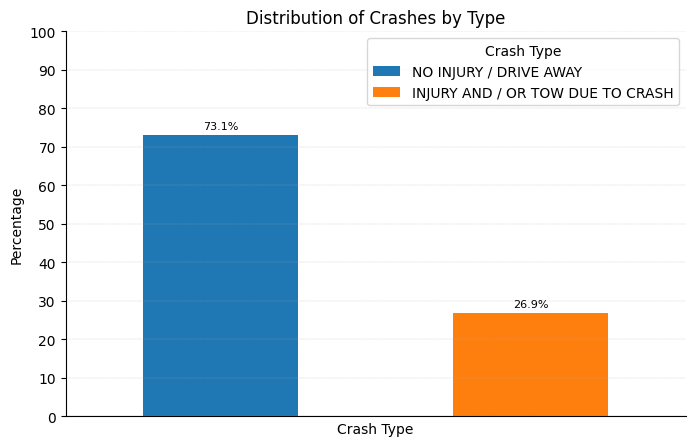

In [22]:
import matplotlib.pyplot as plt

# Define colors for CRASH_TYPE
colors_CRASH_TYPE = plt.cm.tab10(range(len(df_clean['CRASH_TYPE'].value_counts())))

# Create bar plot for CRASH_TYPE
ax1 = (df_clean['CRASH_TYPE'].value_counts(normalize=True) * 100).plot.bar(
    figsize=(8, 5),
    xlabel="Crash Type",
    ylabel="Percentage",
    title="Distribution of Crashes by Type",
    xticks=[],
    color=colors_CRASH_TYPE,
)

# Set y-axis limits and grid
ax1.set_ylim(0, 100)
ax1.set_yticks(range(0, 101, 10))
ax1.grid(axis='y', which='major', linestyle='--', linewidth=0.2)

# Add percentage text above bars
for i, (label, value) in enumerate((df_clean['CRASH_TYPE'].value_counts(normalize=True) * 100).items()):
    ax1.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', color='black', fontsize=8)

# Remove upper and right spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add legend with class names
class_names = df_clean['CRASH_TYPE'].value_counts().index.tolist()
ax1.legend(
    handles=ax1.patches,  # Use bar patches as handles
    labels=class_names,   # Class names as labels
    title="Crash Type",
    loc='upper right'
)


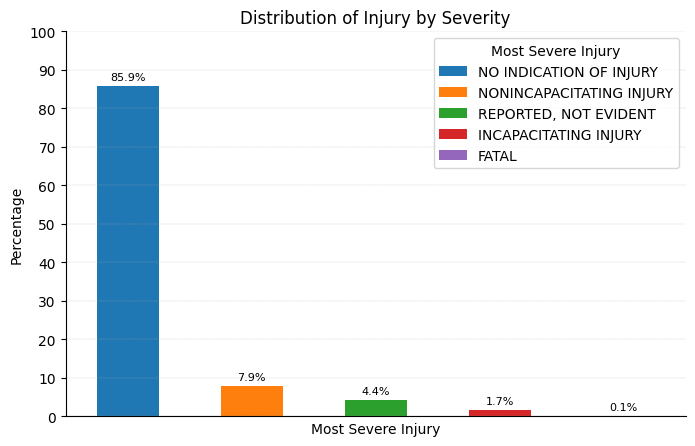

In [17]:
colors_MOST_SEVERE_INJURY = plt.cm.tab10(range(len(df_clean['MOST_SEVERE_INJURY'].value_counts())))

ax2 = (df_clean['MOST_SEVERE_INJURY'].value_counts(normalize=True) * 100).plot.bar(
    figsize=(8, 5),
    xlabel="Most Severe Injury",
    ylabel="Percentage",
    title="Distribution of Injury by Severity",
    xticks=[],
    color=colors_MOST_SEVERE_INJURY,
)

ax2.set_ylim(0, 100)
ax2.set_yticks(range(0, 101, 10))
ax2.grid(axis='y', which='major', linestyle='--', linewidth=0.2)


# percentage text above bars
for i, (label, value) in enumerate((df_clean['MOST_SEVERE_INJURY'].value_counts(normalize=True) * 100).items()):
    ax2.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', color='black', fontsize=8)

# Remove upper and right spines
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

# Add legend with class names
class_names = df_clean['MOST_SEVERE_INJURY'].value_counts().index.tolist()
ax2.legend(
    handles=ax2.patches,  # Use bar patches as handles
    labels=class_names,   # Class names as labels
    title="Most Severe Injury",
    loc='upper right'
)


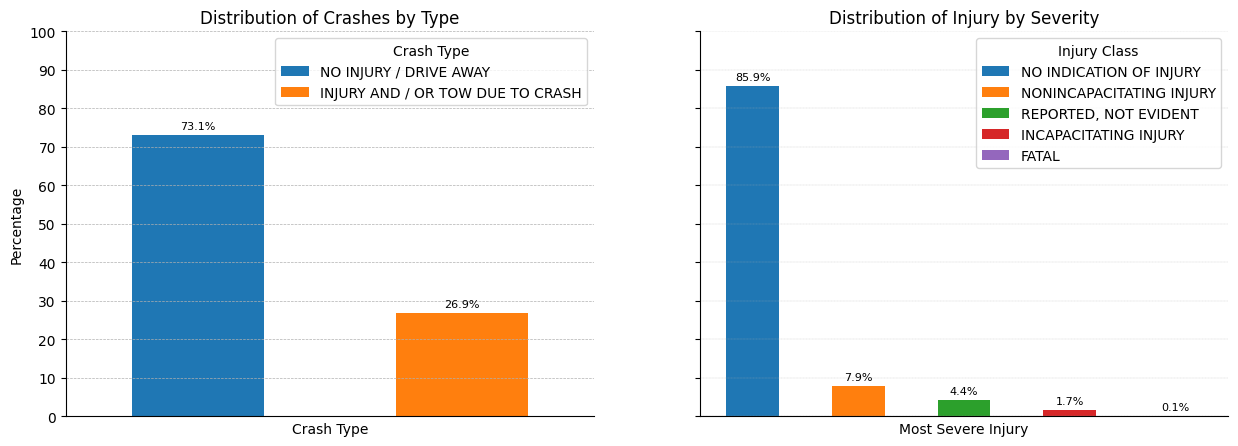

In [23]:


# Define colors for CRASH_TYPE and MOST_SEVERE_INJURY
colors_CRASH_TYPE = plt.cm.tab10(range(len(df_clean['CRASH_TYPE'].value_counts())))
colors_MOST_SEVERE_INJURY = plt.cm.tab10(range(len(df_clean['MOST_SEVERE_INJURY'].value_counts())))

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# Plot 1: CRASH_TYPE
(df_clean['CRASH_TYPE'].value_counts(normalize=True) * 100).plot.bar(
    ax=ax1,
    xlabel="Crash Type",
    ylabel="Percentage",
    title="Distribution of Crashes by Type",
    color=colors_CRASH_TYPE,
)
ax1.set_ylim(0, 100)
ax1.set_yticks(range(0, 101, 10))
ax1.grid(axis='y', which='major', linestyle='--', linewidth=0.5)
for i, (label, value) in enumerate((df_clean['CRASH_TYPE'].value_counts(normalize=True) * 100).items()):
    ax1.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', color='black', fontsize=8)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xticks([])  # Remove x-ticks
class_names_crash = df_clean['CRASH_TYPE'].value_counts().index.tolist()
ax1.legend(handles=ax1.patches, labels=class_names_crash, title="Crash Type", loc='upper right')

# Plot 2: MOST_SEVERE_INJURY
(df_clean['MOST_SEVERE_INJURY'].value_counts(normalize=True) * 100).plot.bar(
    ax=ax2,
    xlabel="Most Severe Injury",
    title="Distribution of Injury by Severity",
    color=colors_MOST_SEVERE_INJURY,
)
ax2.set_ylim(0, 100)
ax2.set_yticks(range(0, 101, 10))
ax2.grid(axis='y', which='major', linestyle='--', linewidth=0.2)
for i, (label, value) in enumerate((df_clean['MOST_SEVERE_INJURY'].value_counts(normalize=True) * 100).items()):
    ax2.text(i, value + 1, f'{value:.1f}%', ha='center', va='bottom', color='black', fontsize=8)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xticks([])  # Remove x-ticks
class_names_injury = df_clean['MOST_SEVERE_INJURY'].value_counts().index.tolist()
ax2.legend(handles=ax2.patches, labels=class_names_injury, title="Injury Class", loc='upper right')

# Adjust layout and show
plt.show()


## Models

In [168]:
del df
df = df_clean.copy()
#del df_clean

In [169]:
factor_cols = [
    'CRASH_DATE_EST_I',
    #'POSTED_SPEED_LIMIT', 
    'TRAFFIC_CONTROL_DEVICE', 
    'DEVICE_CONDITION', 
    'WEATHER_CONDITION', 
    'LIGHTING_CONDITION', 
    'FIRST_CRASH_TYPE', ##### attention to this one! what to do?? keep in x?
    'TRAFFICWAY_TYPE', 
    'ALIGNMENT', 
    'ROADWAY_SURFACE_COND', 
    'ROAD_DEFECT', 
    'REPORT_TYPE', 
    'CRASH_TYPE', 
    'INTERSECTION_RELATED_I',
    'NOT_RIGHT_OF_WAY_I',
    'HIT_AND_RUN_I',
    'DAMAGE', ### attention to this one! potential response var??
    'PRIM_CONTRIBUTORY_CAUSE', 
    'SEC_CONTRIBUTORY_CAUSE',  
    'DOORING_I',
    'WORK_ZONE_I',
    'WORK_ZONE_TYPE', ### > 99% are N/A
    'WORKERS_PRESENT_I',
    'MOST_SEVERE_INJURY', 
    'CRASH_HOUR', 
    'CRASH_DAY_OF_WEEK', 
    'CRASH_MONTH',
    'Crash_Year', # Recently Incuded #
    'Police_district', # Recently Inc, using instead of 'BEAT_OF_OCCURRENCE'
    'LANE_CNT', # Recently Incuded #
]

# Convert to categorical
for col in factor_cols:
    df[col] = df[col].astype('category')



# 5 variables not useful for predictive analysis
not_usefull = ['CRASH_RECORD_ID', 'BEAT_OF_OCCURRENCE',
                'STREET_NO', 'STREET_DIRECTION', 'STREET_NAME',
                'LATITUDE', 'LONGITUDE']


# 2 Date variables
date_vars = ['CRASH_DATE', 'DATE_POLICE_NOTIFIED']
# Report_vs_Police_Notified: hours between crash and notification


# 8 potential response variables
responses = ['CRASH_TYPE', 'MOST_SEVERE_INJURY', 'INJURIES_TOTAL',
             'INJURIES_FATAL', 'INJURIES_INCAPACITATING', 'INJURIES_NON_INCAPACITATING', 'INJURIES_REPORTED_NOT_EVIDENT', 'INJURIES_NO_INDICATION',
             #'DAMAGE',
             ]

In [170]:
# Seed
np.random.seed(480)

### Binomial Logistic Regression


In [ ]:
import patsy

# Binary response variable
# 2 classes:
response = 'CRASH_TYPE'

predictors = df.drop(columns=responses+not_usefull+date_vars).columns

formula = f"{response} ~ {' + '.join(predictors)}"

_, X = patsy.dmatrices(formula, data = df, return_type='dataframe')
y = df[response]

In [172]:
# Random indices
indices = np.random.choice(X.index, 
                           size=5000, 
                           replace=False)

X_sample = X.loc[indices]

y_sample = y.loc[indices]
y_sample.value_counts(normalize=True)

CRASH_TYPE
NO INJURY / DRIVE AWAY             0.7292
INJURY AND / OR TOW DUE TO CRASH   0.2708
Name: proportion, dtype: float64

In [71]:
import os

# CPU cores available
num_cores = os.cpu_count()
print("Total CPU cores available:", num_cores)


Total CPU cores available: 8


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

# Center & Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)


# Lasso Logistic Regression
lasso_logistic = LogisticRegressionCV(
    penalty='l1',
    solver='saga',  # SAGA supports L1 regularization, faster for large datasets & Multi-class/Multinomial
    cv=5, 
    max_iter=1000,
    tol=1e-3,
    random_state=480,
    Cs=10,  # Number of lambda values,
    n_jobs=num_cores-1,  # Use all processors -1
)

lasso_logistic.fit(X_scaled, y)

LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=7, penalty='l1',
                     random_state=480, solver='saga', tol=0.001)

In [175]:
print("Best Lambda:", 1 / lasso_logistic.C_[0])  # Regularization strength (lambda = 1 / C)

Best Lambda: 21.544346900318843


In [176]:
lasso_logistic.coef_.shape # (1, p) for binary response

(1, 268)

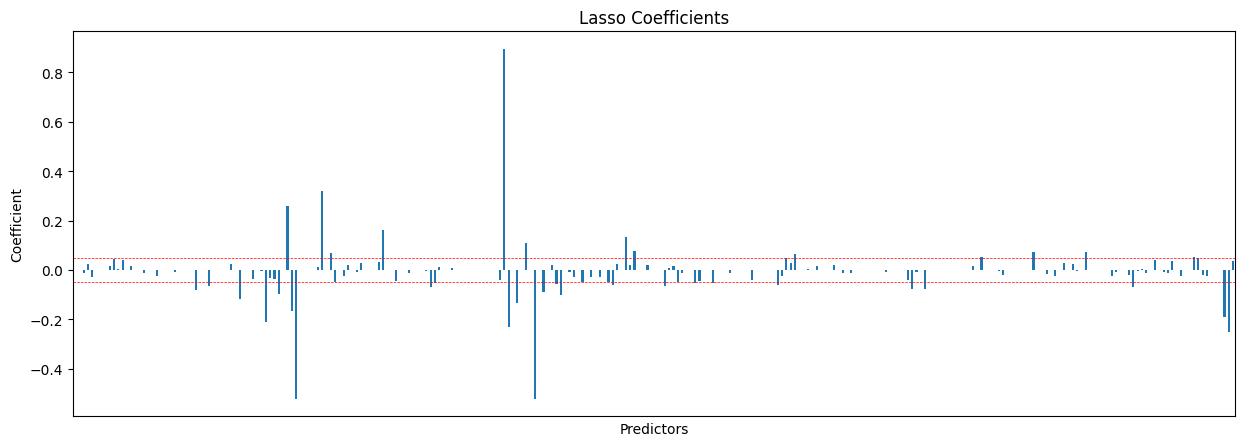

In [177]:
coef_df = pd.DataFrame(
    lasso_logistic.coef_.T,
    index = X.columns, 

    ## Only for multiclass response
    #columns = lasso_logistic.classes_  # Class labels as column names
)

#coef_df[abs(coef_df) < 1e-4] = "." 

# Get coeffs bigger than 0.05, arbitrary threshold
threshold = 5e-2
coef_df[coef_df.abs()>threshold].dropna()

## Plot
coef_df.plot.bar(figsize=(15, 5),
                 title="Lasso Coefficients", xlabel="Predictors", ylabel="Coefficient",
                 legend=False, xticks=[],
                 )

import matplotlib.pyplot as plt
plt.axhline(threshold, color='r', linestyle='--', linewidth=0.5)
plt.axhline(-threshold, color='r', linestyle='--', linewidth=0.5)
plt.show()

### Multinomial Logistic Regression

In [ ]:
import patsy

# Multiclass response variable
# 5 classes
response = 'MOST_SEVERE_INJURY' 

predictors = df.drop(columns=responses+not_usefull+date_vars).columns

formula = f"{response} ~ {' + '.join(predictors)}"

_, X = patsy.dmatrices(formula, data = df, return_type='dataframe')
y = df[response]

In [179]:
# Random indices
indices = np.random.choice(X.index, 
                           size=5000, 
                           replace=False)

X_sample = X.loc[indices]
y_sample = y.loc[indices]

In [180]:
y_sample.value_counts(normalize=True)

MOST_SEVERE_INJURY
NO INDICATION OF INJURY    0.8618
NONINCAPACITATING INJURY   0.0776
REPORTED, NOT EVIDENT      0.0442
INCAPACITATING INJURY      0.0160
FATAL                      0.0004
Name: proportion, dtype: float64

In [181]:
import os

# Number of CPU cores available
num_cores = os.cpu_count()  # or multiprocessing.cpu_count()

print("Total CPU cores available:", num_cores)


Total CPU cores available: 8


In [182]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Standardize and apply Lasso (L1) regularization
lasso_logistic = LogisticRegressionCV(
    penalty='l1',
    solver='saga',  # SAGA supports L1 regularization, faster for large datasets & Multi-class/Multinomial
    cv=5, 
    max_iter=1000,
    tol=1e-3,
    random_state=480,
    Cs=10,  # Number of lambda values,
    n_jobs=num_cores-1,  # Use all processors -1
)

lasso_logistic.fit(X_sample, y_sample)

/Users/Farid/Library/Python/3.11/lib/python/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


LogisticRegressionCV(cv=5, max_iter=1000, n_jobs=7, penalty='l1',
                     random_state=480, solver='saga', tol=0.001)

In [183]:
print("Best Lambda:", 1 / lasso_logistic.C_[0])  # Regularization strength (lambda = 1 / C)

Best Lambda: 2.782559402207126


In [184]:
lasso_logistic.coef_.shape # (1, p) for binary response, (n_classes:5, p) for multiclass response

(5, 268)

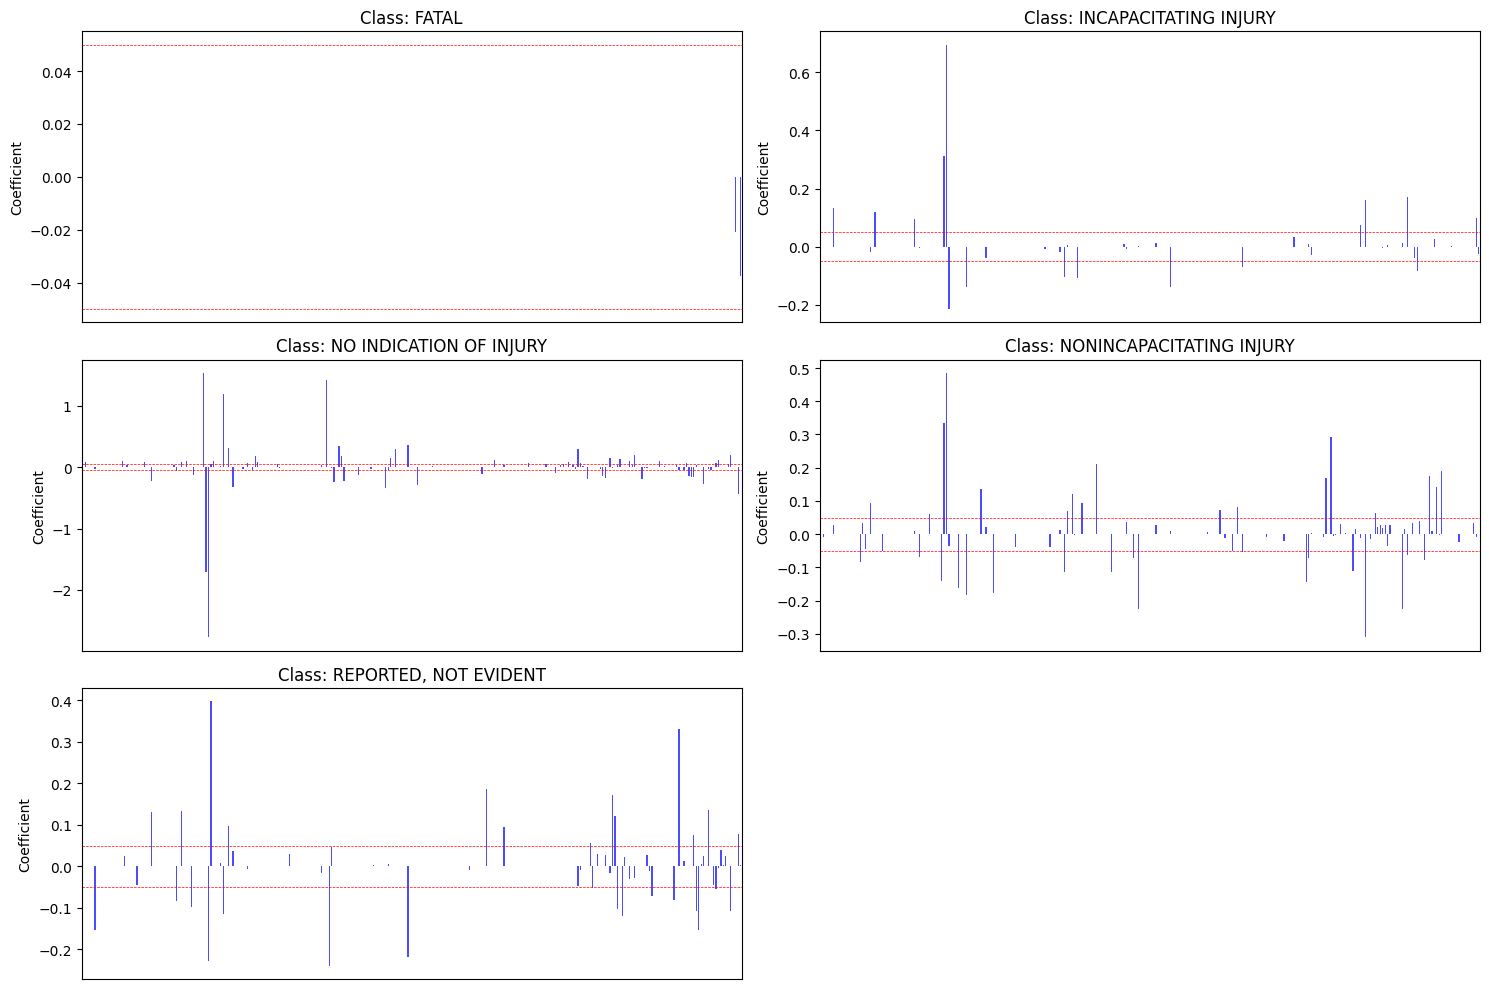

In [ ]:
coef_df = pd.DataFrame(
    lasso_logistic.coef_.T,
    index = X.columns, 

    ## Only for multiclass response
    columns = lasso_logistic.classes_  # Class labels as column names
)

#coef_df[abs(coef_df) < 1e-4] = "." 

# Get coeffs bigger than 0.05, arbitrary threshold
threshold = 5e-2
coef_df[coef_df.abs()>threshold].dropna()


# Plot
n_classes = coef_df.shape[1]  

fig, axes = plt.subplots(3, 2, figsize=(15, 10))
axes = axes.flatten()  

## Plot for each class
for i, class_label in enumerate(coef_df.columns):
    ax = axes[i]
    coef_series = coef_df[class_label]
    
    # coef Bar plot
    coef_series.plot.bar(ax=ax, color='b', alpha=0.7, 
                         title=f"Class: {class_label}")
    
    # threshold
    ax.axhline(threshold, color='r', linestyle='--', linewidth=0.5)
    ax.axhline(-threshold, color='r', linestyle='--', linewidth=0.5)
    
    ax.set_xticks([])
    ax.set_ylabel("Coefficient")

# Hide empty subplot (6th one in a 3x2 grid)
if n_classes < len(axes):
    for j in range(n_classes, len(axes)):
        fig.delaxes(axes[j])


plt.tight_layout()
plt.show()